# Building a Sentiment Classifier Based on the Tweet Sentiment Extraction Dataset

**Goal:** Conduct an analysis of the dataset, perform text data vectorization using bag-of-words and TF-IDF methods, compare them, build a classifier, and conduct error analysis.

**Dataset:**
The data is taken from this competition on Kaggle: https://www.kaggle.com/competitions/tweet-sentiment-extraction/data?select=train.csv

The original competition has a slightly different task, but we will focus on building a classifier for now.

### Task 1. Loading and Familiarizing with the Dataset

- Download the dataset `train.csv` from the link and familiarize yourself with its structure.
- Display the first 5 rows and basic statistics: number of records, column types, number of missing values.
- Remove records that contain missing values.

In [ ]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import re
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, RandomizedSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.multiclass import OneVsRestClassifier

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_auc_score, classification_report


df = pd.read_csv('tweet_sentiment_train.csv.zip')
# D:\GitHub\ML-Course\homework\Topic4\tweet_sentiment_train.csv.zip

df.head(5)

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


In [3]:
df.describe()

,textID,text,selected_text,sentiment
count,27481,27480,27480,27481
unique,27481,27480,22463,3
top,6f7127d9d7,All this flirting going on - The ATG smiles...,good,neutral
freq,1,1,199,11118


In [4]:
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27480 entries, 0 to 27479
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27480 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27480 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


In [ ]:
df.isna().sum()

textID           0
text             0
selected_text    0
sentiment        0
dtype: int64

# Conclusions 1

- We have a total of 27,481 records, all columns are of object type.
- There is one missing value in the text, we will remove it and update the indices.

### Task 2. Exploratory Data Analysis

- Conduct an analysis of the number of classes and the distribution of labels. The classes are located in the `sentiment` column.
- Visualize the distribution of text lengths in characters and draw a conclusion about the lengths of the posts: what length of posts is the most common, what do you see from the distribution?

In [6]:
df.sentiment.value_counts(normalize=True),df.sentiment.value_counts()

(sentiment
 neutral     0.404549
 positive    0.312300
 negative    0.283151
 Name: proportion, dtype: float64,
 sentiment
 neutral     11117
 positive     8582
 negative     7781
 Name: count, dtype: int64)

count    27480.000000
mean        68.330022
std         35.603870
min          3.000000
25%         39.000000
50%         64.000000
75%         97.000000
max        141.000000
Name: character_count, dtype: float64

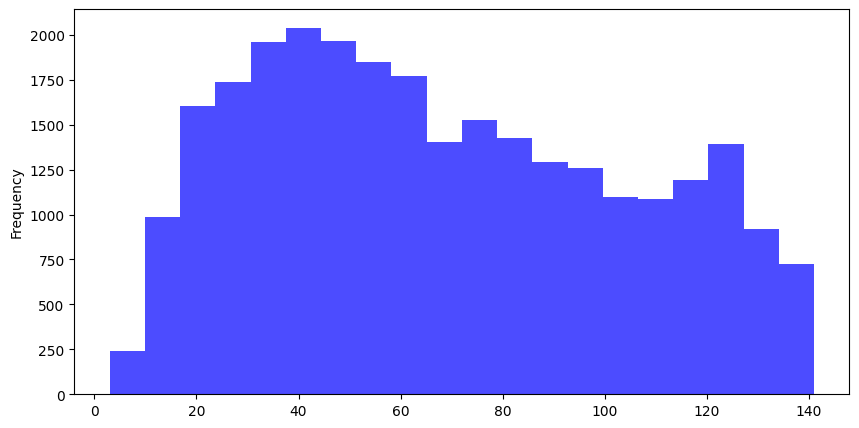

In [7]:
df_enrich = df.copy()
df_enrich['character_count'] = df_enrich['text'].apply(lambda x: len(x))
df_enrich.character_count.plot(kind='hist', bins=20, figsize=(10, 5), color='blue', alpha=0.7)
df_enrich.character_count.describe()

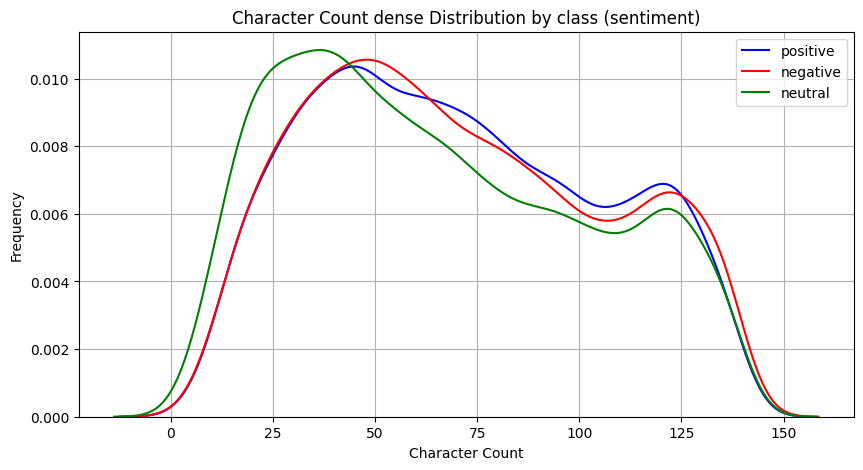

In [ ]:
plt.figure(figsize=(10, 5))
plt.title('Character Count dense Distribution by class (sentiment)') 
plt.xlabel('Character Count')
plt.ylabel('Frequency')
plt.grid()
sns.kdeplot(df_enrich.character_count[df_enrich.sentiment == 'positive'], label='positive', color='blue')
sns.kdeplot(df_enrich.character_count[df_enrich.sentiment == 'negative'], label='negative', color='red')
sns.kdeplot(df_enrich.character_count[df_enrich.sentiment == 'neutral'], label='neutral', color = 'green')
plt.legend()
plt.show()

# Conclusions 2

- There is an imbalance of classes -> F1 score metric for classification:
    - neutral  40.45%
    - positive 31.23%
    - negative 28.31%
- The length of texts ranges from 3 characters to 141, while the distribution of the number of characters across classes is almost identical. The only thing is that the neutral class has a left-shifted peak and tends to have slightly fewer characters (~35). Meanwhile, the negative and positive classes have very similar distributions.
- It is also worth noting the multimodality of all distributions. A second, less pronounced peak is observed around 125 characters.

### Task 3. Preprocessing Text Data and Vectorization with Bag of Words

Our task here is to obtain vectors using the bag of words method from the `text` column by performing text preprocessing. 
The preprocessing should include:
- removal of stopwords in the required language
- tokenization (splitting texts into fragments of 1 word)
- stemming of words using `SnowballStemmer`.
- independently set the number of words in the dictionary for `sklearn.feature_extraction.text.CountVectorizer`. You may need to perform additional analysis for this.

You can also add additional text cleaning methods here, such as removing certain characters or groups of characters, if you notice something you want to remove during the process.

Write code to accomplish this task. Before that, I recommend thoroughly familiarizing yourself with what the `sklearn.feature_extraction.text.CountVectorizer` object does by default.

This task can be completed in two ways - one is very similar to how we did it in the lecture, and the other is somewhat different by regrouping the stages of text processing.

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import PunktSentenceTokenizer
from nltk.stem.snowball import SnowballStemmer


In [ ]:
nltk.download('stopwords') 
nltk.download('punkt') 

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Olhas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Olhas\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [11]:
english_stopwords = stopwords.words('english')
def remove_stopwords(tokens):
    return [word for word in tokens if word.lower() not in english_stopwords]

In [ ]:
stemmer = SnowballStemmer(language='english') 

In [ ]:
import re
def tokenize(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'@\w+', '', text) # remove mentions
    text = re.sub(r'#\w+', '', text) # remove hashtags
    text = re.sub(r'http\S+|www\S+', '', text) # remove URLs
    text = re.sub(r'[^a-z\s]', '', text) # remove special characters
    tokens = word_tokenize(text)

    tokens = remove_stopwords(tokens)
    stem = [stemmer.stem(word) for word in tokens if word not in english_stopwords] 
    return stem

In [14]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Olhas\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

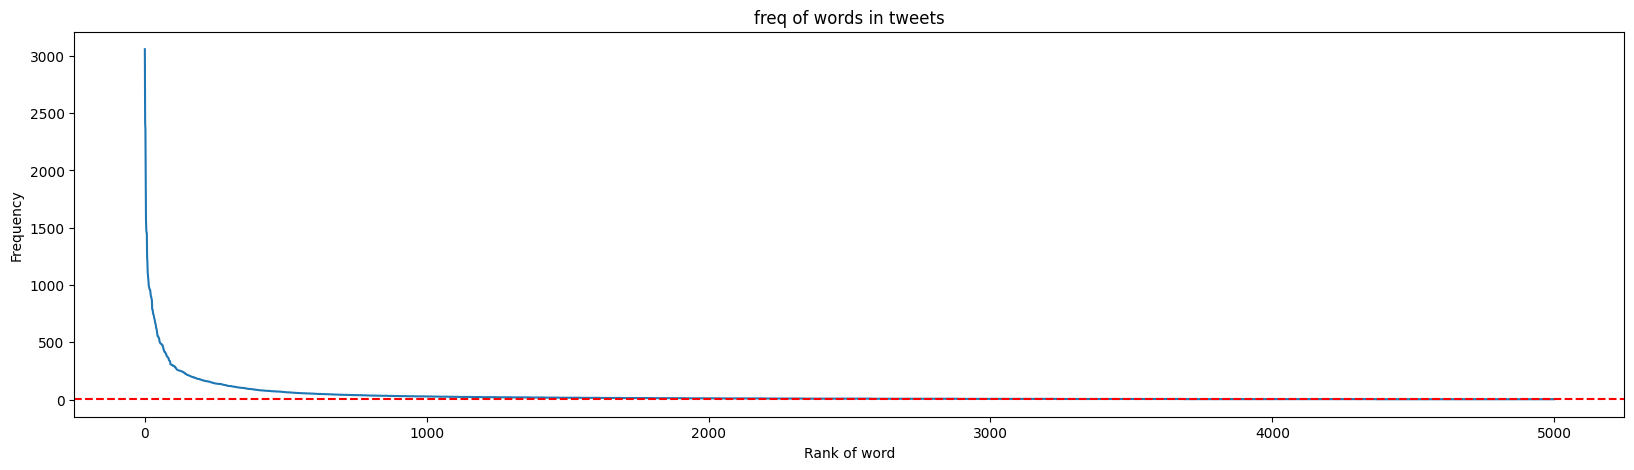

In [ ]:
from collections import Counter

all_tokens = []
for doc in df.text: 
    all_tokens.extend(tokenize(doc))

word_freq = Counter(all_tokens)
most_common = word_freq.most_common()
frequencies = [freq for word, freq in most_common]

import matplotlib.pyplot as plt
plt.figure(figsize=(20, 5))
plt.plot(frequencies[:5000])
plt.axhline(y=3, color='r', linestyle='--')

plt.xlabel("Rank of word")
plt.ylabel("Frequency")
plt.title("freq of words in tweets")
plt.show()

In [16]:
vect = CountVectorizer(tokenizer=tokenize, 
                           stop_words=english_stopwords, 
                           max_features=2000, 
                           ngram_range=(1, 2), 
                           lowercase=True,
                           )
vect.fit(df.text)

d:\Programs\anaconda\envs\ml_course\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
d:\Programs\anaconda\envs\ml_course\Lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['arent', 'couldnt', 'didnt', 'doesnt', 'dont', 'hadnt', 'hasnt', 'havent', 'hed', 'hell', 'hes', 'id', 'ill', 'im', 'isnt', 'itd', 'itll', 'ive', 'mightnt', 'mustnt', 'neednt', 'shant', 'shed', 'shell', 'shes', 'shouldnt', 'shouldv', 'thatll', 'theyd', 'theyll', 'theyr', 'theyv', 'wasnt', 'wed', 'well', 'werent', 'weve', 'wont', 'wouldnt', 'youd', 'youll', 'youv'] not in stop_words.
  warnings.warn(


CountVectorizer(max_features=2000, ngram_range=(1, 2),
                stop_words=['a', 'about', 'above', 'after', 'again', 'against',
                            'ain', 'all', 'am', 'an', 'and', 'any', 'are',
                            'aren', "aren't", 'as', 'at', 'be', 'because',
                            'been', 'before', 'being', 'below', 'between',
                            'both', 'but', 'by', 'can', 'couldn', "couldn't", ...],
                tokenizer=<function tokenize at 0x000002522997F560>)

In [17]:
vect.get_feature_names_out()[:100], vect.get_feature_names_out()[-100:]

(array(['abl', 'absolut', 'abt', 'ac', 'accept', 'access', 'accid',
        'account', 'ace', 'ach', 'across', 'act', 'action', 'activ',
        'actual', 'ad', 'add', 'addict', 'admit', 'ador', 'advic',
        'afford', 'afraid', 'afternoon', 'age', 'ago', 'agre', 'ah', 'aha',
        'ahead', 'ahh', 'ahhh', 'ahhhh', 'aim', 'aint', 'air', 'airport',
        'alarm', 'album', 'alcohol', 'alex', 'allergi', 'allow', 'almost',
        'alon', 'along', 'alot', 'alreadi', 'alright', 'also', 'although',
        'alway', 'amaz', 'america', 'american', 'angel', 'anim', 'announc',
        'annoy', 'anoth', 'anoth one', 'answer', 'anybodi', 'anymor',
        'anyon', 'anyth', 'anytim', 'anyway', 'apart', 'app', 'appar',
        'appear', 'appl', 'appli', 'appreci', 'area', 'arent', 'argh',
        'arm', 'around', 'arriv', 'art', 'articl', 'asap', 'ashley', 'ask',
        'asleep', 'assign', 'aswel', 'ate', 'atm', 'attack', 'attempt',
        'attend', 'attent', 'august', 'australia', 'avail', 

In [ ]:
inputs = vect.transform(df.text)  # transform the text data into a vectorized format

# Conclusions 3

- We will load English stop words and create a function remove_stopwords.
- To split the text into tokens, we will create a function tokenize that:
    - converts all words to lowercase
    - removes special characters, links, hashtags (without their removal, classifiers performed worse)
    - applies stemming to words

- After this, we can pass our created function to CountVectorizer. Additionally, we will set the parameter ngram_range=(1, 2) which allows considering both individual words (unigrams) and pairs of words (bigrams) (the dictionary contains words like 'work tomorrow', 'work weekend').
- To determine the dictionary length parameter, we will additionally analyze all texts to assess the overall frequency of word occurrences. The graph shows that the frequency of words sharply drops starting from 1000 and around 2000 it reaches 1-2 times. We will trim the dictionary to 2000 because other words occur extremely rarely (although they may also be useful).

### Task 4. Building a Classifier

- Split the data indices into training and testing sets in the chosen ratio. Using the obtained indices, form the sets for training the classifier `X_train_bow, X_test_bow, y_train, y_test`.
- Train a classifier (for example, Logistic Regression, Decision Tree, or one of the boosting algorithms) on the data vectorized using the bag-of-words method. Try several models and choose the most accurate one :)
- Output information that allows for assessing the quality of the classification.
- Evaluate the quality of the final classification: is it good or not very good?

In [19]:
inputs.shape, df.shape

((27480, 2000), (27480, 4))

In [ ]:
train_index, test_index = train_test_split(df.index, test_size=0.2, stratify=df.sentiment, random_state=42)

X_train_bow = inputs[train_index]
X_test_bow = inputs[test_index]
y_train = df.sentiment[train_index]
y_test = df.sentiment[test_index]

X_train_bow.shape, X_test_bow.shape, y_train.shape, y_test.shape    

((21984, 2000), (5496, 2000), (21984,), (5496,))

In [21]:
labels = ['negative','neutral','positive']
encoder = LabelEncoder()
encoder.fit(labels)
y_train_encoded = encoder.transform(y_train)  # Encode training labels
y_test_encoded = encoder.transform(y_test)    # Encode test labels

In [22]:
def evaluate_model(model, inputs, targets, name=''):
  y_preds = model.predict(inputs)
  # labels = model.classes_
  labels_tex = ['negative','neutral','positive']

  print(classification_report(targets, y_preds, target_names=labels))
  f1 = f1_score(targets, y_preds, average='weighted')
  print("F1 score: {:.2f}".format(f1))

  cm = confusion_matrix(targets, y_preds, normalize='true')

  plt.figure()
  ax = sns.heatmap(cm, annot=True, cmap = 'Blues',
                   xticklabels=labels_tex, yticklabels=labels_tex)
  plt.xlabel('Prediction')
  plt.ylabel('Target')
  plt.title('{} Confusion Matrix'.format(name))
  plt.show()

              precision    recall  f1-score   support

    negative       0.74      0.74      0.74      6225
     neutral       0.74      0.74      0.74      8894
    positive       0.80      0.81      0.80      6865

    accuracy                           0.76     21984
   macro avg       0.76      0.76      0.76     21984
weighted avg       0.76      0.76      0.76     21984

F1 score: 0.76


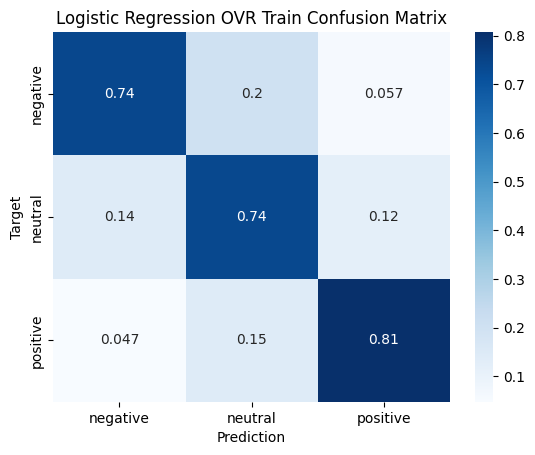

              precision    recall  f1-score   support

    negative       0.67      0.68      0.68      1556
     neutral       0.66      0.66      0.66      2223
    positive       0.75      0.74      0.74      1717

    accuracy                           0.69      5496
   macro avg       0.69      0.69      0.69      5496
weighted avg       0.69      0.69      0.69      5496

F1 score: 0.69


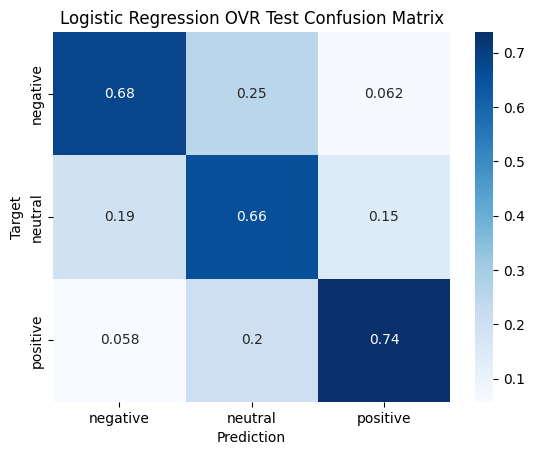

In [23]:
lr = LogisticRegression(random_state=42, class_weight='balanced', max_iter=2000, solver='saga')
ovr_model = OneVsRestClassifier(lr)
ovr_model.fit(X_train_bow, y_train_encoded)
evaluate_model(ovr_model, X_train_bow, y_train_encoded, 'Logistic Regression OVR Train')
evaluate_model(ovr_model, X_test_bow, y_test_encoded, 'Logistic Regression OVR Test')

In [24]:
# Decision Tree Classifier

params = {
    'criterion': ['gini', 'entropy'],
    'max_depth': np.arange(2, 40, 2),
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5, 10],
    'max_features': ['sqrt', 'log2'],
    'class_weight': ['balanced', None]
}
dt = DecisionTreeClassifier(random_state=42)
randomSearch = RandomizedSearchCV(estimator=dt,
                           param_distributions=params,
                           n_iter=50,
                           scoring='f1_weighted',
                           cv=3,
                           verbose=1,
                           n_jobs=-1
                          )
randomSearch.fit(X_train_bow, y_train_encoded)
best_params = randomSearch.best_params_

Fitting 3 folds for each of 50 candidates, totalling 150 fits


Best parameters found:  {'min_samples_split': 10, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'max_depth': np.int64(34), 'criterion': 'entropy', 'class_weight': None}
              precision    recall  f1-score   support

    negative       0.63      0.21      0.32      6225
     neutral       0.49      0.86      0.63      8894
    positive       0.77      0.49      0.60      6865

    accuracy                           0.56     21984
   macro avg       0.63      0.52      0.51     21984
weighted avg       0.62      0.56      0.53     21984

F1 score: 0.53


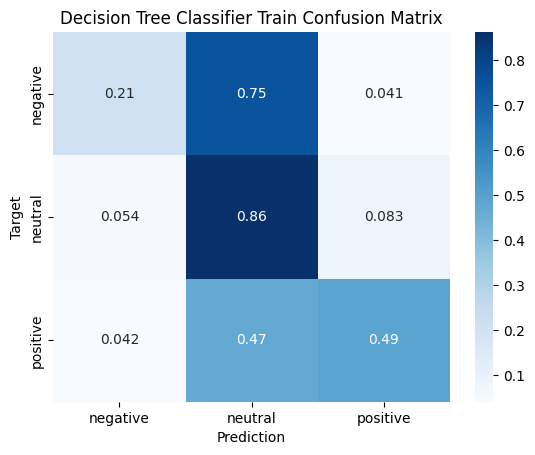

              precision    recall  f1-score   support

    negative       0.58      0.20      0.30      1556
     neutral       0.49      0.85      0.62      2223
    positive       0.77      0.48      0.60      1717

    accuracy                           0.55      5496
   macro avg       0.61      0.51      0.50      5496
weighted avg       0.60      0.55      0.52      5496

F1 score: 0.52


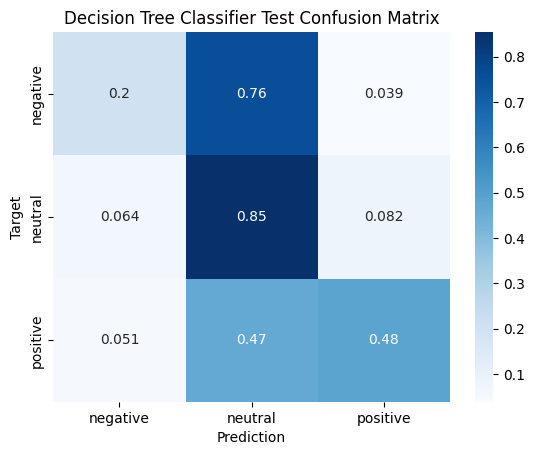

In [25]:
print("Best parameters found: ", best_params)
dt_best = randomSearch.best_estimator_
# Evaluate the model on the training set
evaluate_model(dt_best, X_train_bow, y_train_encoded, 'Decision Tree Classifier Train')
# Evaluate the model on the test set
evaluate_model(dt_best, X_test_bow, y_test_encoded, 'Decision Tree Classifier Test')

d:\Programs\anaconda\envs\ml_course\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:51:51] WARNING: D:\bld\xgboost-split_1738880195977\work\src\learner.cc:740: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

    negative       0.88      0.73      0.80      6225
     neutral       0.76      0.89      0.82      8894
    positive       0.88      0.83      0.85      6865

    accuracy                           0.83     21984
   macro avg       0.84      0.82      0.82     21984
weighted avg       0.83      0.83      0.83     21984

F1 score: 0.83


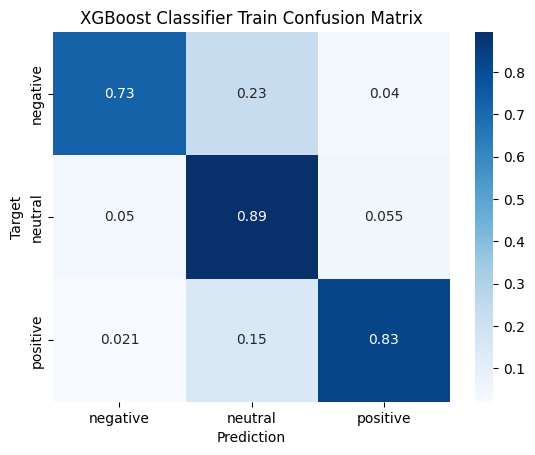

              precision    recall  f1-score   support

    negative       0.73      0.62      0.67      1556
     neutral       0.65      0.75      0.69      2223
    positive       0.77      0.72      0.74      1717

    accuracy                           0.70      5496
   macro avg       0.72      0.70      0.70      5496
weighted avg       0.71      0.70      0.70      5496

F1 score: 0.70


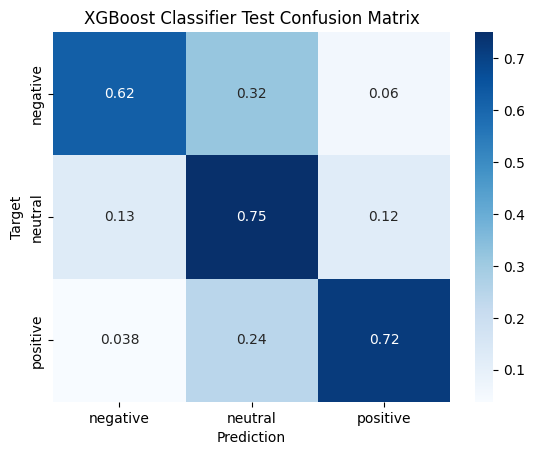

CPU times: total: 1min 17s
Wall time: 5.7 s


In [26]:
%%time
# XGBoost Classifier
# params = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': np.arange(2, 40, 2),
#     'learning_rate': [0.01, 0.1, 0.2],
#     'subsample': [0.5, 0.7, 1.0],
#     'gamma': [0, 0.1, 0.2],
#     'class_weight': ['balanced', None]
# }

xgb = XGBClassifier(random_state=42,
                    learning_rate=0.1, 
                    n_estimators=400, 
                    max_depth=15, subsample=0.8, 
                    gamma=0.1, class_weight='balanced',
                    )   
xgb.fit(X_train_bow, y_train_encoded)

evaluate_model(xgb, X_train_bow, y_train_encoded, 'XGBoost Classifier Train')
evaluate_model(xgb, X_test_bow, y_test_encoded, 'XGBoost Classifier Test')

# Conclusions 4

- Let's save the split of indices into separate variables (train_index, test_index)
- Since we have a multi-class classification, we will convert the target into numbers using LabelEncoder [0 == 'negative', 1 == 'neutral', 2 == 'positive']

- For logistic regression, we will use OneVsRestClassifier
- For Decision Tree, we will find the best parameters using RandomizedSearchCV
- For XGBClassifier, we will manually select optimal parameters to reduce runtime

|model|train f1|test f1|test f1 Negative| test f1 Neutral| test f1 Positive|
|-----|--------|-------|----------------|----------------|-----------------|
|Log.regress|76|69|68|66|74|
|Decision tree|53|53|29|63|62|
|XGB|83|70|67|69|74|

- At this stage, the best model is XGB, which provides good results. It has the highest quality on the test (F1 = 70), with a good balance between class recognition. However, there may be overfitting, as there is a significant gap between the training and test F1 (83 and 70 respectively)
- There is also the most confusion when we label the positive or negative class as neutral (which is logical, as sometimes it is difficult for people to find the boundary between them). However, we have a very small number of errors between the positive and negative classes, which is very good

- It is worth noting that the Decision Tree gave the worst results with very poor ability to separate the negative class

### Task 5. Analysis of Word Importance in the Obtained Classifier

- For the model you have chosen, conduct an analysis of word importance (features): which words (tokens) have the most influence on sentiment determination? Does it make sense to you that these particular symbols have the most/least influence?

In [27]:
feature_importances = xgb.feature_importances_
feature_names = vect.get_feature_names_out()
df_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
df_importances = df_importances.sort_values(by='importance', ascending=False)
display(df_importances.head(20))

,feature,importance
790,happi,0.005929
1727,thank,0.005224
798,hate,0.004018
52,amaz,0.003953
875,hurt,0.003604
1475,sad,0.003314
1242,nice,0.003244
104,awesom,0.003239
566,fail,0.003139
551,excit,0.003112


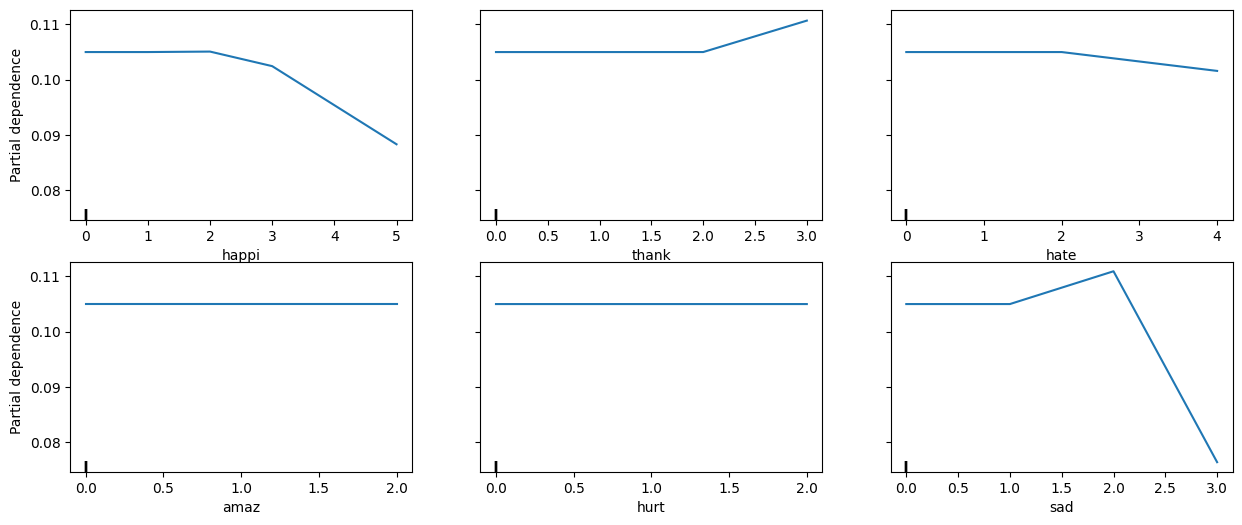

In [ ]:

from sklearn.inspection import PartialDependenceDisplay

importance = xgb.feature_importances_

feat_importances = pd.Series(importance, index=vect.get_feature_names_out())

valid_features = [f for f in feat_importances.nlargest(6).index 
                if f in vect.get_feature_names_out()]

X_train_dense = X_train_bow.toarray() 

fig, ax = plt.subplots(figsize=(15, 6) ) 

PartialDependenceDisplay.from_estimator(
    xgb,
    X_train_dense,
    features=valid_features,
    feature_names=vect.get_feature_names_out(),
    target=2,  # positive class,
    grid_resolution=50,
    ax=ax
)
plt.show()


# Conclusions 5
- The importance of features seems logical; we see emotionally charged words that most influence the model. For most words, one can logically guess which class they influence the most. Moreover, all coefficients are quite low, which may indicate that we have a lot of important words, and many of them significantly impact the model.
- Additionally, through the analysis of the positive class using PartialDependenceDisplay, we can see how a specific feature correlates with the class. It seems logical that with an increase in the frequency of the words "hate" and "sad," the dependency on the positive class decreases -> a negative correlation with the class for these words. At the same time, we have a positive dependency with the word "thank" (which also makes sense for the positive class). However, the question arises as to why the word "happy" has a negative dependency; it would be more logical for it to increase the probability of the positive class (perhaps it is often used sarcastically, or it is part of certain phrases that have a negative context; we should also consider the possibility of issues with tokenization).

### Task 6. Text Vectorization using TF-IDF. Training the Classifier, Analyzing Accuracy and Word Influence.

- Perform text vectorization using the TfidfVectorizer. Implement the vectorization so that the preprocessing includes all the same steps as in the case of using Bag of Words vectorization.

- Train the same classifier on the TF-IDF vectors, splitting the dataset into train and test sets so that the training set contains all the same records as in the previous task (this is important for comparing results).

- Analyze the quality of classification by outputting the necessary metrics. Has the quality of classification improved?

- Which tokens have the most influence on the results when training the classifier with TF-IDF vectors? Compare with the most important tokens from the Bag of Words vectorization. Which vectorization would you choose for the final implementation of the solution? Justify your choice.

In [ ]:
tfidf_vect = TfidfVectorizer(tokenizer=tokenize,
                           stop_words=english_stopwords, 
                           max_features=2000, 
                           ngram_range=(1, 2), 
                           lowercase=True
                           )
tfidf_vect.fit(df.text)
inputs_tfidf = tfidf_vect.transform(df.text)
inputs_tfidf.shape, df.shape

d:\Programs\anaconda\envs\ml_course\Lib\site-packages\sklearn\feature_extraction\text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
d:\Programs\anaconda\envs\ml_course\Lib\site-packages\sklearn\feature_extraction\text.py:402: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['arent', 'couldnt', 'didnt', 'doesnt', 'dont', 'hadnt', 'hasnt', 'havent', 'hed', 'hell', 'hes', 'id', 'ill', 'im', 'isnt', 'itd', 'itll', 'ive', 'mightnt', 'mustnt', 'neednt', 'shant', 'shed', 'shell', 'shes', 'shouldnt', 'shouldv', 'thatll', 'theyd', 'theyll', 'theyr', 'theyv', 'wasnt', 'wed', 'well', 'werent', 'weve', 'wont', 'wouldnt', 'youd', 'youll', 'youv'] not in stop_words.
  warnings.warn(


((27480, 2000), (27480, 4))

In [28]:
X_train_tfidf = inputs_tfidf[train_index]  
X_test_tfidf = inputs_tfidf[test_index]

d:\Programs\anaconda\envs\ml_course\Lib\site-packages\xgboost\core.py:158: UserWarning: [11:34:37] WARNING: D:\bld\xgboost-split_1738880195977\work\src\learner.cc:740: 
Parameters: { "class_weight" } are not used.

  warnings.warn(smsg, UserWarning)


              precision    recall  f1-score   support

    negative       0.93      0.79      0.85      6225
     neutral       0.80      0.93      0.86      8894
    positive       0.92      0.86      0.89      6865

    accuracy                           0.87     21984
   macro avg       0.89      0.86      0.87     21984
weighted avg       0.88      0.87      0.87     21984

F1 score: 0.87


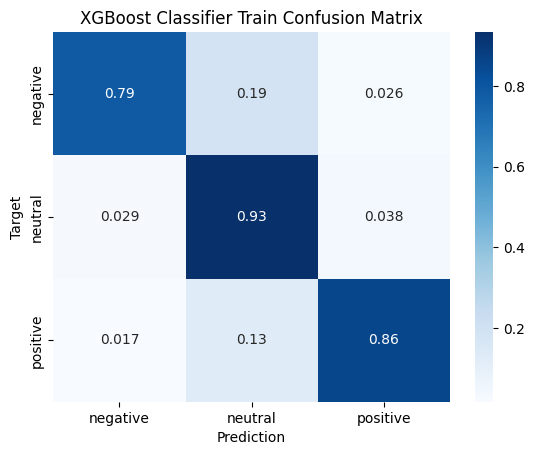

              precision    recall  f1-score   support

    negative       0.72      0.61      0.66      1556
     neutral       0.63      0.73      0.68      2223
    positive       0.76      0.72      0.74      1717

    accuracy                           0.69      5496
   macro avg       0.70      0.69      0.69      5496
weighted avg       0.70      0.69      0.69      5496

F1 score: 0.69


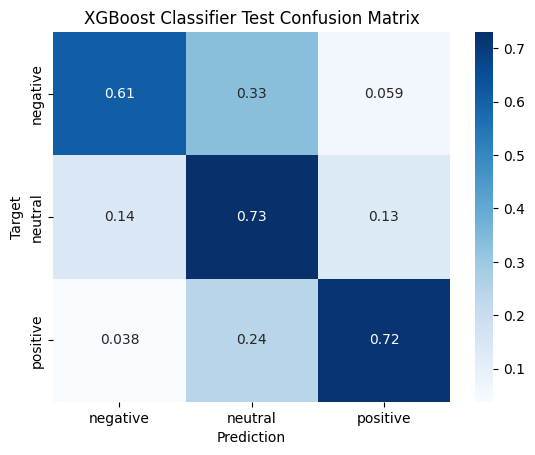

CPU times: total: 17min 26s
Wall time: 1min 21s


In [29]:
%%time
xgb_tfifd = XGBClassifier(random_state=42,
                    learning_rate=0.1, 
                    n_estimators=400, 
                    max_depth=15, subsample=0.8, 
                    gamma=0.1, class_weight='balanced',
                    )   
xgb_tfifd.fit(X_train_tfidf, y_train_encoded)

evaluate_model(xgb_tfifd, X_train_tfidf, y_train_encoded, 'XGBoost Classifier Train')
evaluate_model(xgb_tfifd, X_test_tfidf, y_test_encoded, 'XGBoost Classifier Test')

In [30]:
feature_importances_tf = xgb_tfifd.feature_importances_
feature_names_tf = tfidf_vect.get_feature_names_out()
df_importances_tf = pd.DataFrame({'feature': feature_names_tf, 'importance': feature_importances_tf})
df_importances_tf = df_importances_tf.sort_values(by='importance', ascending=False)
display(df_importances_tf.head(20))

,feature,importance
790,happi,0.005394
1727,thank,0.003936
875,hurt,0.003841
798,hate,0.003376
1661,suck,0.003349
1475,sad,0.003232
52,amaz,0.003222
104,awesom,0.002873
566,fail,0.002857
1658,stupid,0.002709


In [31]:
print("XGBoost Classifier with TF-IDF features")
print((df_importances_tf.feature[:10]).tolist())
print("XGBoost Classifier with BoW features")
print((df_importances.feature[:10]).tolist())

XGBoost Classifier with TF-IDF features
['happi', 'thank', 'hurt', 'hate', 'suck', 'sad', 'amaz', 'awesom', 'fail', 'stupid']
XGBoost Classifier with BoW features
['happi', 'thank', 'hate', 'amaz', 'hurt', 'sad', 'nice', 'awesom', 'fail', 'excit']


In [32]:
perd_proba_tfidf = xgb_tfifd.predict_proba(X_test_tfidf)
pred_proba_bow = xgb.predict_proba(X_test_bow)
display(np.round(perd_proba_tfidf[:5], 4), np.round(pred_proba_bow[:5], 4))

array([[0.286 , 0.5775, 0.1365],
       [0.9256, 0.0658, 0.0087],
       [0.7463, 0.2259, 0.0279],
       [0.9723, 0.0233, 0.0044],
       [0.0328, 0.2332, 0.734 ]], dtype=float32)

array([[0.4125, 0.4303, 0.1572],
       [0.9246, 0.0721, 0.0034],
       [0.9901, 0.0089, 0.001 ],
       [0.8478, 0.1399, 0.0123],
       [0.0337, 0.3525, 0.6137]], dtype=float32)

# Conclusions 6

- We vectorize words using TfidfVectorizer with similar settings and will also trim the vocabulary to 2000 words.
- Using the saved indices train_index, test_index, we will create new subarrays of data and train the model that performed best for BoW -> XGB.

|model|train f1|test f1|test f1 Negative| test f1 Neutral| test f1 Positive|train time|
|-----|--------|-------|----------------|----------------|-----------------|--------|
|XGB Tf-IDF|87|69|66|68|74|1min 21s|
|XGB BoW|83|70|67|69|74|5.87s|

- It seems that we have identical metrics on the test. However, there is a much greater overfitting of the classifier for Tf-IDF (training = 87, test 69). This can be explained by the fact that we used the same classifier with the same parameters that we tuned for BoW in XGB, so they may be suboptimal for the new text split.
- At this stage, I would choose **BoW for text vectorization**, as it is simpler and the classifier trained significantly faster, which can be an important characteristic when implementing the model. Although it is worth noting that Tf-IDF has potential if we improve the classifier parameters, as even with strong overfitting we have the same test accuracy as in BoW, where overfitting is slightly less.
- When analyzing the top important features, we see that they are very similar between the two types of text vectorization, and we can say that for the current task they focus on the same key words.

### Task 7. Analysis of classification errors with TF-IDF vectorization.

- Analyze which instances the classifier makes mistakes on when using TF-IDF vectorization.
- Based on the analysis, suggest 3 ways to improve the quality of classification.

In [35]:
df_results = pd.DataFrame({'text': df.text[test_index], 'sentiment': y_test, 'pred_proba_tfidf': (perd_proba_tfidf).tolist(), 'pred_proba_bow': pred_proba_bow.tolist()})
df_results['pred_tfidf'] = df_results['pred_proba_tfidf'].apply(lambda x: encoder.inverse_transform([np.argmax(x)])[0])
df_results['pred_bow'] = df_results['pred_proba_bow'].apply(lambda x: encoder.inverse_transform([np.argmax(x)])[0])
df_results.head()

,text,sentiment,pred_proba_tfidf,pred_proba_bow,pred_tfidf,pred_bow
23413,Reading and taking notes but undertanding none...,negative,"[0.28595444560050964, 0.5775198936462402, 0.13...","[0.4125385880470276, 0.4302853047847748, 0.157...",neutral,neutral
27363,so sad emma u sad to be leaving the show? ****,negative,"[0.9255653619766235, 0.06577729433774948, 0.00...","[0.9245599508285522, 0.07208763808012009, 0.00...",negative,negative
21260,Freakin` frustrated why can`t my coach realize...,negative,"[0.7462503910064697, 0.2258712500333786, 0.027...","[0.9900749325752258, 0.008876154199242592, 0.0...",negative,negative
11166,is feeling so bored... i miss school time,negative,"[0.9722999334335327, 0.02328651025891304, 0.00...","[0.8477880358695984, 0.13993678987026215, 0.01...",negative,negative
24608,wow this morning 8.15 hrs ding dong breakfasts...,positive,"[0.03277871757745743, 0.23318257927894592, 0.7...","[0.033732905983924866, 0.3525324761867523, 0.6...",positive,positive


In [ ]:
df_tfidf_results = df_results.copy()
df_tfidf_results.drop(columns=['pred_bow','pred_proba_bow'], inplace=True)
# Round the probabilities to 4 decimal places
df_tfidf_results['pred_proba_tfidf'] = df_tfidf_results['pred_proba_tfidf'].apply(lambda x: np.round(x, 4))

In [ ]:
# Ground truth is negative, pred is negative +
# true is negative, pred is NEUTRAL 
display(
    df_tfidf_results[(df_tfidf_results['sentiment'] == 'negative') & (df_tfidf_results['pred_tfidf'] == 'negative')].head(10),
    df_tfidf_results[(df_tfidf_results['sentiment'] == 'negative') & (df_tfidf_results['pred_tfidf'] == 'neutral')].head(10),
)

,text,sentiment,pred_proba_tfidf,pred_tfidf
27363,so sad emma u sad to be leaving the show? ****,negative,"[0.9256, 0.0658, 0.0087]",negative
21260,Freakin` frustrated why can`t my coach realize...,negative,"[0.7463, 0.2259, 0.0279]",negative
11166,is feeling so bored... i miss school time,negative,"[0.9723, 0.0233, 0.0044]",negative
22354,I am sad... Tanner wasn`t invited to the Panth...,negative,"[0.6089, 0.3818, 0.0093]",negative
26877,so hot in the office as air con been broken fo...,negative,"[0.6408, 0.2203, 0.1389]",negative
22099,For _inLaPush because she misses Quil so... F...,negative,"[0.878, 0.1114, 0.0106]",negative
3823,my teeth and head hurts,negative,"[0.9476, 0.0358, 0.0166]",negative
10246,Youtube isn`t working...and I wanted to watch ...,negative,"[0.4646, 0.3921, 0.1433]",negative
15056,aw. wasn`**** sad?! give ginger a little pat ...,negative,"[0.9705, 0.0273, 0.0023]",negative
6262,"6:29 pm - ok, let`s go now through #bowman #st...",negative,"[0.7217, 0.2521, 0.0263]",negative


,text,sentiment,pred_proba_tfidf,pred_tfidf
23413,Reading and taking notes but undertanding none...,negative,"[0.286, 0.5775, 0.1365]",neutral
7935,2 hours after teleconference. but can`t go bac...,negative,"[0.4267, 0.4784, 0.0949]",neutral
17085,Im home where i am about 2 drink alone.,negative,"[0.1954, 0.6843, 0.1203]",neutral
8973,"Ah sorry to hear that, just saw pic of chi. a...",negative,"[0.2887, 0.5036, 0.2077]",neutral
27219,I can`t believe you tweeted that. It was our ...,negative,"[0.3095, 0.3685, 0.322]",neutral
20602,kate is leaving me all by my lonesome,negative,"[0.1768, 0.7203, 0.1028]",neutral
3805,ask to create a fake competetion and declare...,negative,"[0.1912, 0.7285, 0.0803]",neutral
25571,thers not many peole tweeting tonight... well ...,negative,"[0.4144, 0.4148, 0.1709]",neutral
3328,"- l`d come if u could, but Australia is just ...",negative,"[0.1622, 0.6612, 0.1766]",neutral
5965,"so, why the hell are we going to school for 2 ...",negative,"[0.3462, 0.5067, 0.1471]",neutral


In [39]:
df_tfidf_results.text.loc[23413]

'Reading and taking notes but undertanding none of it  ... HELP!'

In [ ]:
# Ground truth is positive, pred is positive +
# true is positive, pred is NEUTRAL 
display(
    df_tfidf_results[(df_tfidf_results['sentiment'] == 'positive') & (df_tfidf_results['pred_tfidf'] == 'positive')].head(10),
    df_tfidf_results[(df_tfidf_results['sentiment'] == 'positive') & (df_tfidf_results['pred_tfidf'] == 'neutral')].head(10),
)

,text,sentiment,pred_proba_tfidf,pred_tfidf
24608,wow this morning 8.15 hrs ding dong breakfasts...,positive,"[0.0328, 0.2332, 0.734]",positive
24966,"Don`t worry, you`ll get your stamina back soo...",positive,"[0.0812, 0.2562, 0.6627]",positive
15657,"MIT bookstore has best book selection, but it`...",positive,"[0.0466, 0.2129, 0.7406]",positive
5449,when living in Spain..you can NEVER take a hot...,positive,"[0.0283, 0.137, 0.8347]",positive
23696,hay naku!!madaya ka talaga ah hehe ..hey happ...,positive,"[0.0009, 0.0079, 0.9911]",positive
20474,"Rachel Allens date bars, so easy to make htt...",positive,"[0.2587, 0.2875, 0.4538]",positive
2489,bahah that would be really funny she would be...,positive,"[0.0502, 0.1625, 0.7874]",positive
20938,"honestly last night was amazing, everything wa...",positive,"[0.0009, 0.0008, 0.9984]",positive
12868,Kudos! love some homemade french toast!,positive,"[0.0142, 0.1464, 0.8394]",positive
3760,8am math final wish me luck,positive,"[0.1182, 0.1088, 0.773]",positive


,text,sentiment,pred_proba_tfidf,pred_tfidf
20626,i`m just sooo in love....i think,positive,"[0.2198, 0.6218, 0.1584]",neutral
4831,yum. Do you do home delivery,positive,"[0.0907, 0.4828, 0.4265]",neutral
19359,Having a wonderful piece of cake for lunch - w...,positive,"[0.1243, 0.6169, 0.2588]",neutral
18943,_Jamie I guess ! I was really suprised..,positive,"[0.2643, 0.5686, 0.1671]",neutral
793,_KittyKat hello new follower haha!! how are ya?,positive,"[0.0437, 0.6686, 0.2878]",neutral
16610,I just KNEW you`d get that!,positive,"[0.1442, 0.7791, 0.0767]",neutral
7738,Went to get my car inspection sticker got giga...,positive,"[0.1577, 0.4722, 0.3701]",neutral
972,Heading off to Hollywood Studios today Manta ...,positive,"[0.1004, 0.5188, 0.3807]",neutral
13751,is chilling at home,positive,"[0.1518, 0.6547, 0.1935]",neutral
9076,lucky to be where i belong,positive,"[0.1685, 0.6033, 0.2282]",neutral


In [ ]:
# misclassification positive/negative
display(
    df_tfidf_results[(df_tfidf_results['sentiment'] == 'positive') & (df_tfidf_results['pred_tfidf'] == 'negative')].head(10),
    df_tfidf_results[(df_tfidf_results['sentiment'] == 'negative') & (df_tfidf_results['pred_tfidf'] == 'positive')].head(10),
)

,text,sentiment,pred_proba_tfidf,pred_tfidf
27111,i want so bad to go to the mcfly`s concert,positive,"[0.5746, 0.2988, 0.1266]",negative
27190,friday night is my fav night of the week but n...,positive,"[0.9017, 0.0828, 0.0155]",negative
13827,Getting some DMs asking where I fell off to th...,positive,"[0.5891, 0.3779, 0.0331]",negative
17082,aww what kind of dog do u have? I have a chih...,positive,"[0.581, 0.211, 0.208]",negative
4581,"dude, I can safely say I was blown away when ...",positive,"[0.4794, 0.1586, 0.362]",negative
17342,"$900 cheque to cash tomorrow, why I didn`t get...",positive,"[0.3736, 0.3147, 0.3117]",negative
252,almost died. Laptop screen was set to 100% bri...,positive,"[0.9063, 0.0764, 0.0173]",negative
5971,that couldn`t be more true! I like ur momma`s...,positive,"[0.5782, 0.3168, 0.105]",negative
6799,167 SQL queries to display one single deal pag...,positive,"[0.564, 0.1048, 0.3312]",negative
3226,"Bank Holiday Bliss - Jeremy Kyle, without even...",positive,"[0.5, 0.222, 0.278]",negative


,text,sentiment,pred_proba_tfidf,pred_tfidf
17483,"Awww, *hugs* I wish I could help.",negative,"[0.0955, 0.1435, 0.7611]",positive
8916,_Happy_EmoX lmao. Lucky! It`s 10 minutes on fo...,negative,"[0.1706, 0.2346, 0.5948]",positive
22556,I wish I could just go for a drive..or a movie...,negative,"[0.1714, 0.1758, 0.6528]",positive
19647,"Oh, don`t spoil my fun, lol",negative,"[0.0278, 0.0682, 0.904]",positive
24468,So glad the days almost over... Another nite o...,negative,"[0.2208, 0.1198, 0.6594]",positive
21971,_Music I was not hugged,negative,"[0.0853, 0.3312, 0.5834]",positive
26766,not good enough!,negative,"[0.1593, 0.128, 0.7127]",positive
3550,Sunburnt Gutted! Hope it`s faded by tmw!,negative,"[0.1346, 0.1318, 0.7335]",positive
13854,favorite shirt ruined:death by bleach #fb,negative,"[0.1248, 0.4003, 0.4749]",positive
7525,"i wish i could offer a hug right now, so bad",negative,"[0.2733, 0.1961, 0.5306]",positive


In [42]:
df_tfidf_results.text.loc[17483]

' Awww, *hugs* I wish I could help.'

# Conclusions 7

- First of all, it is worth focusing on cases where negative/positive texts are classified as neutral. Because in these cases, we make the most mistakes.
- In some cases, it is unclear why the original texts were marked as a certain class. It seems that those who did the labeling did not always correctly determine where the negative, positive, or neutral class is (after all, this is partly subjective).
- Ground truth was marked as positive (although to me they do not sound positive):
    - i need a hug i dnt feel so good
    - friday night is my fav night of the week but now I have to go to stupid dog training classes
    - The test today was killer. I didn`t even manage to finish on time
- Ground truth was marked as neutral (although they do not sound that way):
    - put my dog to sleep  I love you abby RIP<3 

- It was also interesting to explore cases where the classifier makes diametrically opposite mistakes between the positive and negative classes. For example, for **"not good enough!"** Ground truth == negative, but we recognized it as a positive class (it seems that negations got into the stop words and were removed, although they are very important here. We need to return to the text preparation stage more carefully).
- We also have mistakes in complex sentences, where there are several parts. One part of the sentence may describe something positive, while the other may negate it, and the classifier cannot recognize which part is more important and makes incorrect conclusions.
- I also got the impression that sometimes the "positive" and "negative" classes have different meanings. Sometimes "negative" refers to hate and negative statements, but from time to time, it is encountered that texts marked as "negative" contain supportive content (for example, **Awww, *hugs* I wish I could help.** sounds like supportive text and I would say it is positively colored, because the person offers support, but originally it is stated that it is negative).

Ways to improve classification:
1. Manually redo the class labels (ideally, take the opinion of several people and derive an average).
2. Add more instances where there is a fine line between classes. Where the classifier makes more mistakes - it needs to be provided with more representative data.
3. Implement multi-label classification, and if the classifier is unsure whether it is a neutral class or emotionally colored, output two labels. This way we will get different options: positive, positively-neutral, neutral, negatively-neutral, negative. Because sometimes, based on the probability distribution, it is clear that classifiers are very uncertain between two classes (for example, class probabilities [0.4125, 0.4303, 0.1572]).
4. Balance the classes. The current distribution is not bad (40%, 31%, 28%), but the dominance of neutral texts is too pronounced.